In [1]:
%matplotlib inline

# Imports
import numpy as np
import pandas as pd
import quandl
quandl.ApiConfig.api_key = 'EnterAPIKeyHere' # Enter Quandl API key to download stock prices data

from IPython.display import clear_output
from matplotlib import pyplot as plt
import seaborn as sns
import pylab as pl

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# Get S&P500 stock symbols, sectors, and subsectors from wikipedia
wiki_table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies',header=0)[0]
symbols = list(wiki_table['Ticker symbol'])
symbols[symbols.index("BKNG")] = 'PCLN' #Updated stock symbol
symbols[symbols.index("WELL")] = 'HCN' #Updated stock symbol
sectors = list(wiki_table['GICS Sector'])
subsectors = list(wiki_table['GICS Sub Industry'])

In [3]:
# Retrieve daily stock prices in 2017
data = []
for s, i in zip(symbols,np.arange(len(symbols))):
    print s
    clear_output(wait=True)
    data.append(quandl.get("WIKI/" + s.replace("-", "_").replace(".", "_"), start_date="2017-01-01", end_date="2017-12-31")) #stored as pandas df

ZTS


In [4]:
# Build dataframe with stocks as rows, days as columns, daily changes as the values, and add sector and subsector labels
stocks_df = pd.DataFrame(index=symbols, columns=data[3].index) # Use the dates from a stock with data from all 250 trading days
for s, i in zip(data,np.arange(len(data))):
    s['Daily change'] = (s['Adj. Close']-s['Adj. Open'])*100/s['Adj. Open']
    stocks_df.iloc[i,:] = s['Daily change']
    
stocks_df['Sector']=sectors

# Encode Sector
le = LabelEncoder()
stocks_df['Sector_encoded'] = le.fit_transform(stocks_df['Sector'])
stocks_df.head()

Date,2017-01-03 00:00:00,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-09 00:00:00,2017-01-10 00:00:00,2017-01-11 00:00:00,2017-01-12 00:00:00,2017-01-13 00:00:00,2017-01-17 00:00:00,...,2017-12-19 00:00:00,2017-12-20 00:00:00,2017-12-21 00:00:00,2017-12-22 00:00:00,2017-12-26 00:00:00,2017-12-27 00:00:00,2017-12-28 00:00:00,2017-12-29 00:00:00,Sector,Sector_encoded
MMM,-0.436168,0.162894,-0.308538,0.530205,-0.616696,-0.439783,0.713356,0.265582,-0.106994,0.146893,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Industrials,5
ABT,1.07834,0.768049,1.17227,2.7204,-0.122579,1.17618,0.0730816,-0.171611,0.441718,0.565527,...,0.264784,0.511193,-0.384952,-0.297723,-0.0175408,0.665616,0.0348189,-0.920139,Health Care,4
ABBV,-0.810553,1.03768,0.615336,-0.142452,0.642633,0.0312256,-3.53424,0.83923,1.04319,0.178138,...,-0.588832,-0.490346,-0.112222,0.142755,-0.407539,0.368362,-0.407373,-1.4571,Health Care,4
ACN,-0.783779,-0.145411,-1.70115,1.13923,-0.981574,0.104402,0.623917,0.138384,1.38708,0.094893,...,0.144737,-0.446106,-1.21084,-1.02901,-0.0979496,0.0522057,0.0716799,-0.867707,Information Technology,6
ATVI,0.548847,1.60457,1.17333,-0.105402,-1.02389,1.88479,1.89758,0.359066,0.698035,0,...,-1.81543,-1.42398,0.883584,-0.539624,-1.22976,-0.518297,0.0947269,-0.424595,Information Technology,6


In [5]:
# PCA
X = stocks_df.iloc[:,:250].values.astype(float) # convert pd dataframe to numpy array
X = np.nan_to_num(X) #replace NaNs with 0s
pca = PCA(n_components=250)
scores = pca.fit_transform(X)
# Add first 2 PCs to dataframe
stocks_df['PC1'] = scores[:,0]
stocks_df['PC2'] = scores[:,1]

# K-Means Clustering

In [6]:
# K Means clustering into 11 clusters (There are 11 stock sectors in the actual data)
km = KMeans(n_clusters=11, n_jobs=-1, random_state = 42)
km_pred = km.fit(stocks_df[['PC1','PC2']])
stocks_df['K-Means Cluster'] = km_pred.labels_ # Add the cluster determined by KMeans to stocks_df
stocks_df.head()

Date,2017-01-03 00:00:00,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-09 00:00:00,2017-01-10 00:00:00,2017-01-11 00:00:00,2017-01-12 00:00:00,2017-01-13 00:00:00,2017-01-17 00:00:00,...,2017-12-22 00:00:00,2017-12-26 00:00:00,2017-12-27 00:00:00,2017-12-28 00:00:00,2017-12-29 00:00:00,Sector,Sector_encoded,PC1,PC2,K-Means Cluster
MMM,-0.436168,0.162894,-0.308538,0.530205,-0.616696,-0.439783,0.713356,0.265582,-0.106994,0.146893,...,NaN,NaN,NaN,NaN,NaN,Industrials,5,-2.542212,-2.026947,10
ABT,1.07834,0.768049,1.17227,2.7204,-0.122579,1.17618,0.0730816,-0.171611,0.441718,0.565527,...,-0.297723,-0.0175408,0.665616,0.0348189,-0.920139,Health Care,4,-3.136476,-1.996376,10
ABBV,-0.810553,1.03768,0.615336,-0.142452,0.642633,0.0312256,-3.53424,0.83923,1.04319,0.178138,...,0.142755,-0.407539,0.368362,-0.407373,-1.4571,Health Care,4,-3.432805,-3.164033,8
ACN,-0.783779,-0.145411,-1.70115,1.13923,-0.981574,0.104402,0.623917,0.138384,1.38708,0.094893,...,-1.02901,-0.0979496,0.0522057,0.0716799,-0.867707,Information Technology,6,-3.774094,-0.905603,10
ATVI,0.548847,1.60457,1.17333,-0.105402,-1.02389,1.88479,1.89758,0.359066,0.698035,0,...,-0.539624,-1.22976,-0.518297,0.0947269,-0.424595,Information Technology,6,-12.358810,3.888986,6


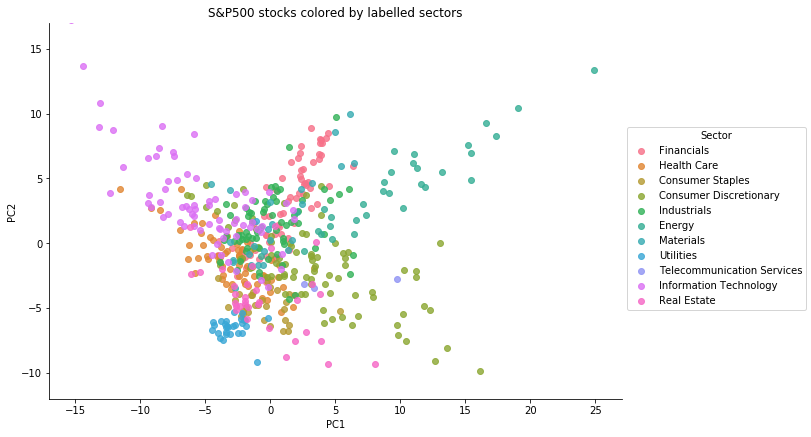

In [7]:
# Visualize stocks according to their sector
sns.lmplot('PC1', 'PC2', data=stocks_df, hue='Sector', fit_reg=False, size=6,aspect=1.5, palette='husl',
                                        hue_order=['Financials', 'Health Care', 'Consumer Staples', 'Consumer Discretionary', 'Industrials', 'Energy', 'Materials', 'Utilities', 'Telecommunication Services', 'Information Technology', 'Real Estate']);
plt.xlim(-17,27)
plt.ylim(-12, 17)
plt.title('S&P500 stocks colored by labelled sectors');

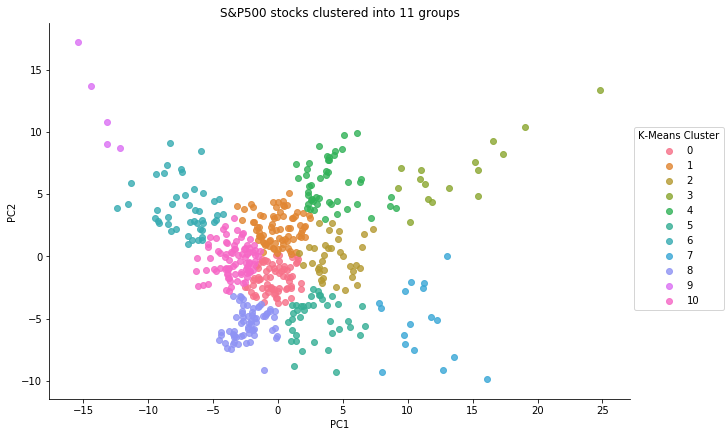

In [8]:
# Visualize clusters predicted by KMeans
sns.lmplot('PC1', 'PC2', data=stocks_df, hue='K-Means Cluster', fit_reg=False, size=6,aspect=1.5, palette='husl');
plt.title('S&P500 stocks clustered into 11 groups');

Conclusion: Stocks within a sector tend to cluster in their daily price changes, and K-means clustering partially recapitulates these clusters.  Can stock sector be predicted from daily percent value changes?

# Classification of Stock Sector using K-Nearest Neighbor 

In [9]:
# Attempt 1: Using the full 250 dimensional features (days) for kNN
Y = stocks_df['Sector_encoded']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state = 42)
clf = KNeighborsClassifier(n_neighbors=11, weights='distance')  # k chosen as roughly sqrt(n)/2
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)

print "The accuracy rate of kNN model using all 250-dimensions is " +str(int(accuracy_score(Y_test,Y_pred)*100)) +"%."

The accuracy rate of kNN model using all 250-dimensions is 81%.


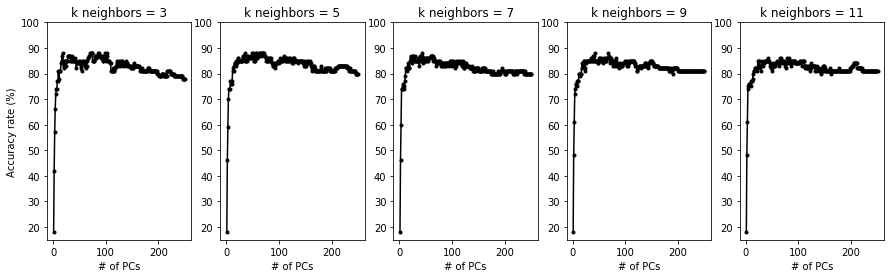

In [10]:
# Attempt 2: Use only the first j reduced Principal Components for kNN
fig, axs = plt.subplots(1,5,figsize=(15,4))
counter = 0;
for k in np.arange(3,12,2):
    PC_n = []
    PC_scores =[]
    for j in np.arange(1,251):
        X_scores = scores[:,:j]
        X_train, X_test, Y_train, Y_test = train_test_split(X_scores,Y, test_size=0.25, random_state = 42)

        clf = KNeighborsClassifier(n_neighbors=k, weights='distance')
        clf.fit(X_train,Y_train)
        Y_pred = clf.predict(X_test)
        cur_score = int(accuracy_score(Y_test,Y_pred)*100)
        PC_n.append(j)
        PC_scores.append(cur_score)
    ax = plt.subplot(1,5,counter+1)
    ax.set_title("k neighbors = "+str(k))
    ax.set_xlabel('# of PCs')
    if counter == 0 : ax.set_ylabel('Accuracy rate (%)')
    plt.plot(PC_n,PC_scores,marker='.',color='k')
    plt.ylim(15,100)
    counter = counter+1

Using the first 30 PCs and the 5 nearest neighbours seems to give good results

In [11]:
# Using the chosen parameters to calculate accuracy rate of kNN model
X_scores = scores[:,:31]
X_train, X_test, Y_train, Y_test = train_test_split(X_scores,Y, test_size=0.25, random_state = 42)
clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
cur_score = int(accuracy_score(Y_test,Y_pred)*100)
print "The accuracy rate of kNN model using 5 PC dimensions is " +str(int(accuracy_score(Y_test,Y_pred)*100)) +"%."

The accuracy rate of kNN model using 5 PC dimensions is 87%.


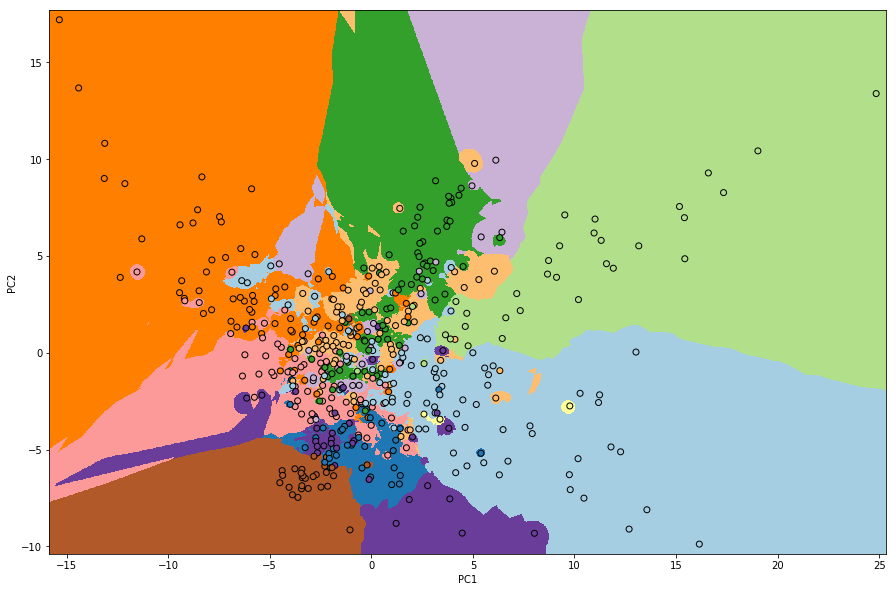

In [12]:
# Visualize classification boundary on first 2 PCs
h = .02 # step size in mesh
X_scores = scores[:,:2]
clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
clf.fit(X_scores,Y)
x_min, x_max = X_scores[:,0].min() - .5, X_scores[:,0].max() + .5
y_min, y_max = X_scores[:,1].min() - .5, X_scores[:,1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Plot
Z = Z.reshape(xx.shape)
pl.figure(figsize=(15,10))
pl.set_cmap(pl.cm.Paired)
pl.pcolormesh(xx, yy, Z)
pl.scatter(X_scores[:,0], X_scores[:,1], c=Y, marker='o', edgecolors='k');
pl.xlabel('PC1')
pl.ylabel('PC2');

Conclusion: Stock sector type can be determined with 87% accuracy using only daily percent stock value changes.